In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import  textblob
#import xgboost
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
#nltk.download('wordnet')
from textblob import Word

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [2]:
reviews = pd.read_excel('E:/Data Science Material/AssignmentToSubmit/Text Mining/BankReviews.xlsx')

In [3]:
reviews.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [4]:
df = reviews

Basic Exploratory Analysis

In [5]:
df['Reviews'] = df['Reviews'].astype(str)
df['count_sent']=df["Reviews"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word']=df["Reviews"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df["Reviews"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df["Reviews"].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word']+1)

#punctuation count
df["count_punctuations"] =df["Reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df["Reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
df["mean_word_len"] = df["Reviews"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['Reviews'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count']  = df['Reviews'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count']  = df['Reviews'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'pron')) 

Creating user defined functions for clean the text and pre-process the data

In [6]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return(text)

In [22]:
stop = set(nltk.corpus.stopwords.words('english'))

In [23]:
import string
def pre_process(text):
    #text = text.str.replace('/','')                           #Replacing the / with none
    #text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    #text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,']", "", text)      #Replacing special character with none
    #text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    #text = text.apply(lambda x: " ".join(x.translate(str.maketrans('', '', string.punctuation)) for x in x.split() if x.isalpha()))
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
    #text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
    #text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
    #text = text.apply(lambda x: " ".join(stemmer_func(word) for word in x.split()))        #Stemming
    #text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))   #lemmatization
    #text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return(text)

Calculating Sentiment analysis using Textblob module


In [7]:
df['ReviewCleaned'] = df["Reviews"].apply(lambda x: clean_text(x))

In [25]:
df['ReviewCleaned'] = pre_process(df["ReviewCleaned"])

In [26]:
df['sentiment'] = df["ReviewCleaned"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [27]:
# We use textblob utility to calculate the reviews polarity
def get_Review_type(sentimentType): 
    # set sentiment 
    analysis = sentimentType
    if analysis > 0: 
        return 'positive'
    elif analysis == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [28]:
df['sentiment'].head()
df['sentiment'].iloc[0]

0.43333333333333335

In [29]:
df['ReviewType'] = df['sentiment'].apply(get_Review_type)

In [30]:
df.head()

,Date,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,...,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count,ReviewCleaned,sentiment,ReviewType
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,6.300000,4,...,0,"{'smoothly.': 1, 'Thank': 1, 'us': 1, 'move': ...",8,3,1,1,3,great job wyndham capital person professional ...,0.433333,positive
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,1,25,23,159,6.115385,4,...,0,"{'excellent': 1, 'Matthew!': 1, 'Richardson': ...",7,3,4,2,4,matthew richardson professional helpful helped...,0.550000,positive
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,1,79,64,462,5.775000,8,...,1,"{'mortgage': 1, 'past': 1, 'if': 1, 'that': 1,...",24,10,5,8,8,past experience wyndham mortgage would without...,-0.033869,negative
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,1,108,78,605,5.550459,9,...,1,"{'money.': 1, 'found': 1, 'Brad': 4, 'We': 2, ...",30,17,8,7,11,dealing brad thomka beginning started stressfu...,0.061238,positive
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,1,59,47,341,5.683333,6,...,1,"{'this': 1, 'that': 1, 'way.': 1, 'family': 1,...",16,9,4,4,8,cant express grateful support zach provided fa...,0.086667,positive


In [31]:
df1 = df.filter(['Reviews','sentiment','Stars','ReviewType','ReviewCleaned']).head(24)

In [32]:
df1.head()

,Reviews,sentiment,Stars,ReviewType,ReviewCleaned
0,"Great job, Wyndham Capital! Each person was pr...",0.433333,5,positive,great job wyndham capital person professional ...
1,Matthew Richardson is professional and helpful...,0.550000,5,positive,matthew richardson professional helpful helped...
2,We had a past experience with Wyndham Mortgage...,-0.033869,5,negative,past experience wyndham mortgage would without...
3,We have been dealing with Brad Thomka from the...,0.061238,5,positive,dealing brad thomka beginning started stressfu...
4,I can't express how grateful I am for the supp...,0.086667,5,positive,cant express grateful support zach provided fa...


In [33]:
df1[(df1.Stars==5) & (df1['ReviewType']=='negative')]

,Reviews,sentiment,Stars,ReviewType,ReviewCleaned
2,We had a past experience with Wyndham Mortgage...,-0.033869,5,negative,past experience wyndham mortgage would without...


In [34]:
df1[(df1.Stars==1) & (df1['ReviewType']=='positive')]

,Reviews,sentiment,Stars,ReviewType,ReviewCleaned
18,"A good rate but a very frustrating process, co...",0.142857,1,positive,good rate frustrating process constant delays ...
19,They were not upfront. Learn from my mistake.....,0.310000,1,positive,upfront learn mistake trusted loan officer zer...
20,"Initially, the Mortgage Broker was very friend...",0.068750,1,positive,initially mortgage broker friendly assertive p...
21,"Initially, the Mortgage Broker was very friend...",0.068750,1,positive,initially mortgage broker friendly assertive p...


Split the data into train & Test

In [35]:
# define X and y
X = reviews.Reviews
y = reviews.Stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(378,)
(127,)
(378,)
(127,)


In [37]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [38]:
X_train=pre_process(X_train)
X_test=pre_process(X_test)

### Vectorization (Count, Tfidf, Hashing)
        - Charter level
        - Word level
        - n-grams

In [39]:
#Train
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' ,
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)

In [40]:
xtrain_count

<378x596 sparse matrix of type '<class 'numpy.int64'>'
	with 9211 stored elements in Compressed Sparse Row format>

View the document term metrics

In [41]:
dtm=xtrain_count.toarray()

In [42]:
dtm

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [43]:
count_vect.get_feature_names()

['aaron',
 'able',
 'absolutely',
 'accept',
 'accommodating',
 'account',
 'accurate',
 'across',
 'actual',
 'adam',
 'additional',
 'advice',
 'agent',
 'agreed',
 'alex',
 'almost',
 'along',
 'already',
 'also',
 'always',
 'amazing',
 'american',
 'amount',
 'another',
 'answer',
 'answered',
 'answering',
 'answers',
 'anyone',
 'anything',
 'application',
 'apply',
 'appraisal',
 'appraiser',
 'appreciate',
 'appreciated',
 'approved',
 'around',
 'ask',
 'asked',
 'asking',
 'aspects',
 'attention',
 'available',
 'away',
 'awesome',
 'back',
 'bad',
 'balance',
 'bank',
 'banks',
 'barrett',
 'based',
 'became',
 'beginning',
 'beneficial',
 'best',
 'better',
 'beyond',
 'big',
 'bob',
 'brent',
 'broker',
 'business',
 'buy',
 'buyer',
 'buyers',
 'buying',
 'ca',
 'call',
 'called',
 'calling',
 'calls',
 'calm',
 'came',
 'cannot',
 'cant',
 'capital',
 'care',
 'causing',
 'certainly',
 'change',
 'changed',
 'check',
 'chose',
 'chris',
 'circumstances',
 'clear',
 'cli

In [44]:
dtm1=pd.DataFrame(dtm)

In [45]:
dtm1.columns=count_vect.get_feature_names()

In [46]:
dtm1.head()

,aaron,able,absolutely,accept,accommodating,account,accurate,across,actual,adam,...,working,works,would,wouldnt,writing,wrong,wyndham,year,years,yet
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Vectorization (count, tfidf) for both train & test

In [48]:
#Train
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(xtrain_count)

#Test
#count_vect = CountVectorizer()
xtest_count = count_vect.transform(X_test)

#tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.transform(xtest_count)

In [49]:
dtm2=pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())

In [50]:
dtm2.head(10)

,aaron,able,absolutely,accept,accommodating,account,accurate,across,actual,adam,...,working,works,would,wouldnt,writing,wrong,wyndham,year,years,yet
0,0.0,0.0,0.000000,0.133259,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.123737,0.0,0.0,0.0,0.0,0.096250,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.194406,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.130702,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.121363,0.0,0.0,0.0,0.0,0.094403,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.084774,0.175643,0.0,0.0,0.0,0.0,0.000000,0.0
6,0.0,0.0,0.000000,0.000000,0.0,0.0,0.256938,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
7,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.068074,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
8,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
9,0.0,0.0,0.228774,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [51]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', ngram_range=(1, 2), max_features=800)
tfidf_vect_ngram.fit(df['ReviewCleaned'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [52]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern='\w{1,}', ngram_range=(1,2), max_features=800)
tfidf_vect_ngram_chars.fit(df['ReviewCleaned'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

Topic Modeling

In [53]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=50)
X_topics = lda_model.fit_transform(X_train_tfidf)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [54]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['bad done great information steve got phone couldnt process get',
 'honest jason june responsive easy great pleasure awesome mistake service',
 'loan process would us great recommend home work time best',
 'dean use went product provide professionally plan aspects advice needs',
 'timely service always efficient agent pleased simple little completed friendly',
 'great company alex cant june jocovic job rates patient appreciate',
 'jon barrett mr quick extremely close loan nasb mortgage husband',
 'true joey failed positive trusted paperwork throughout refinancing also never',
 'helpful great responsive service work good able customer accommodating buyers',
 'encountered prompt various responses peter despite answered got professional team',
 'kory decision financial felt time make took types life circumstances',
 'wanted could poor questions loan makes also ve check awesome',
 'oriented customer professional i cost quick ve friendly lender family',
 'lender unprofessional number list 

Bank data - Word clouds

In [55]:
frequency_words_wo_stop= {}
for data in reviews['Reviews']:
    tokens = nltk.wordpunct_tokenize(data.lower())
    for token in tokens:
        if token.lower() not in stop:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1
                


In [56]:
frequency_words_wo_stop

{'great': 139,
 'job': 25,
 ',': 1135,
 'wyndham': 16,
 'capital': 12,
 '!': 222,
 'person': 17,
 'professional': 70,
 'helped': 35,
 'us': 207,
 'move': 12,
 'refinance': 70,
 'process': 253,
 'smoothly': 15,
 '.': 1976,
 'thank': 50,
 'matthew': 3,
 'richardson': 1,
 'helpful': 56,
 'find': 19,
 'correct': 1,
 'product': 10,
 'mortgage': 147,
 'much': 38,
 'excellent': 30,
 'service': 99,
 'past': 13,
 'experience': 110,
 'would': 246,
 'without': 29,
 'question': 7,
 'use': 48,
 'needed': 29,
 '!!': 24,
 'went': 70,
 'beyond': 25,
 'extra': 19,
 'mile': 8,
 'right': 28,
 'wrong': 7,
 'encountered': 7,
 'servicer': 3,
 'dealing': 14,
 'previous': 13,
 'loan': 313,
 'pulled': 4,
 'together': 8,
 'found': 16,
 'viable': 3,
 'option': 8,
 'ultimately': 5,
 'saved': 7,
 'money': 22,
 'highly': 65,
 'recommend': 156,
 'brad': 7,
 'thomka': 3,
 'team': 113,
 'needs': 27,
 'sincerest': 2,
 'thanks': 61,
 'ed': 2,
 '&': 30,
 'lind': 1,
 'beginning': 32,
 'started': 17,
 'stressful': 24,
 'ti

In [57]:
from wordcloud import WordCloud ,STOPWORDS

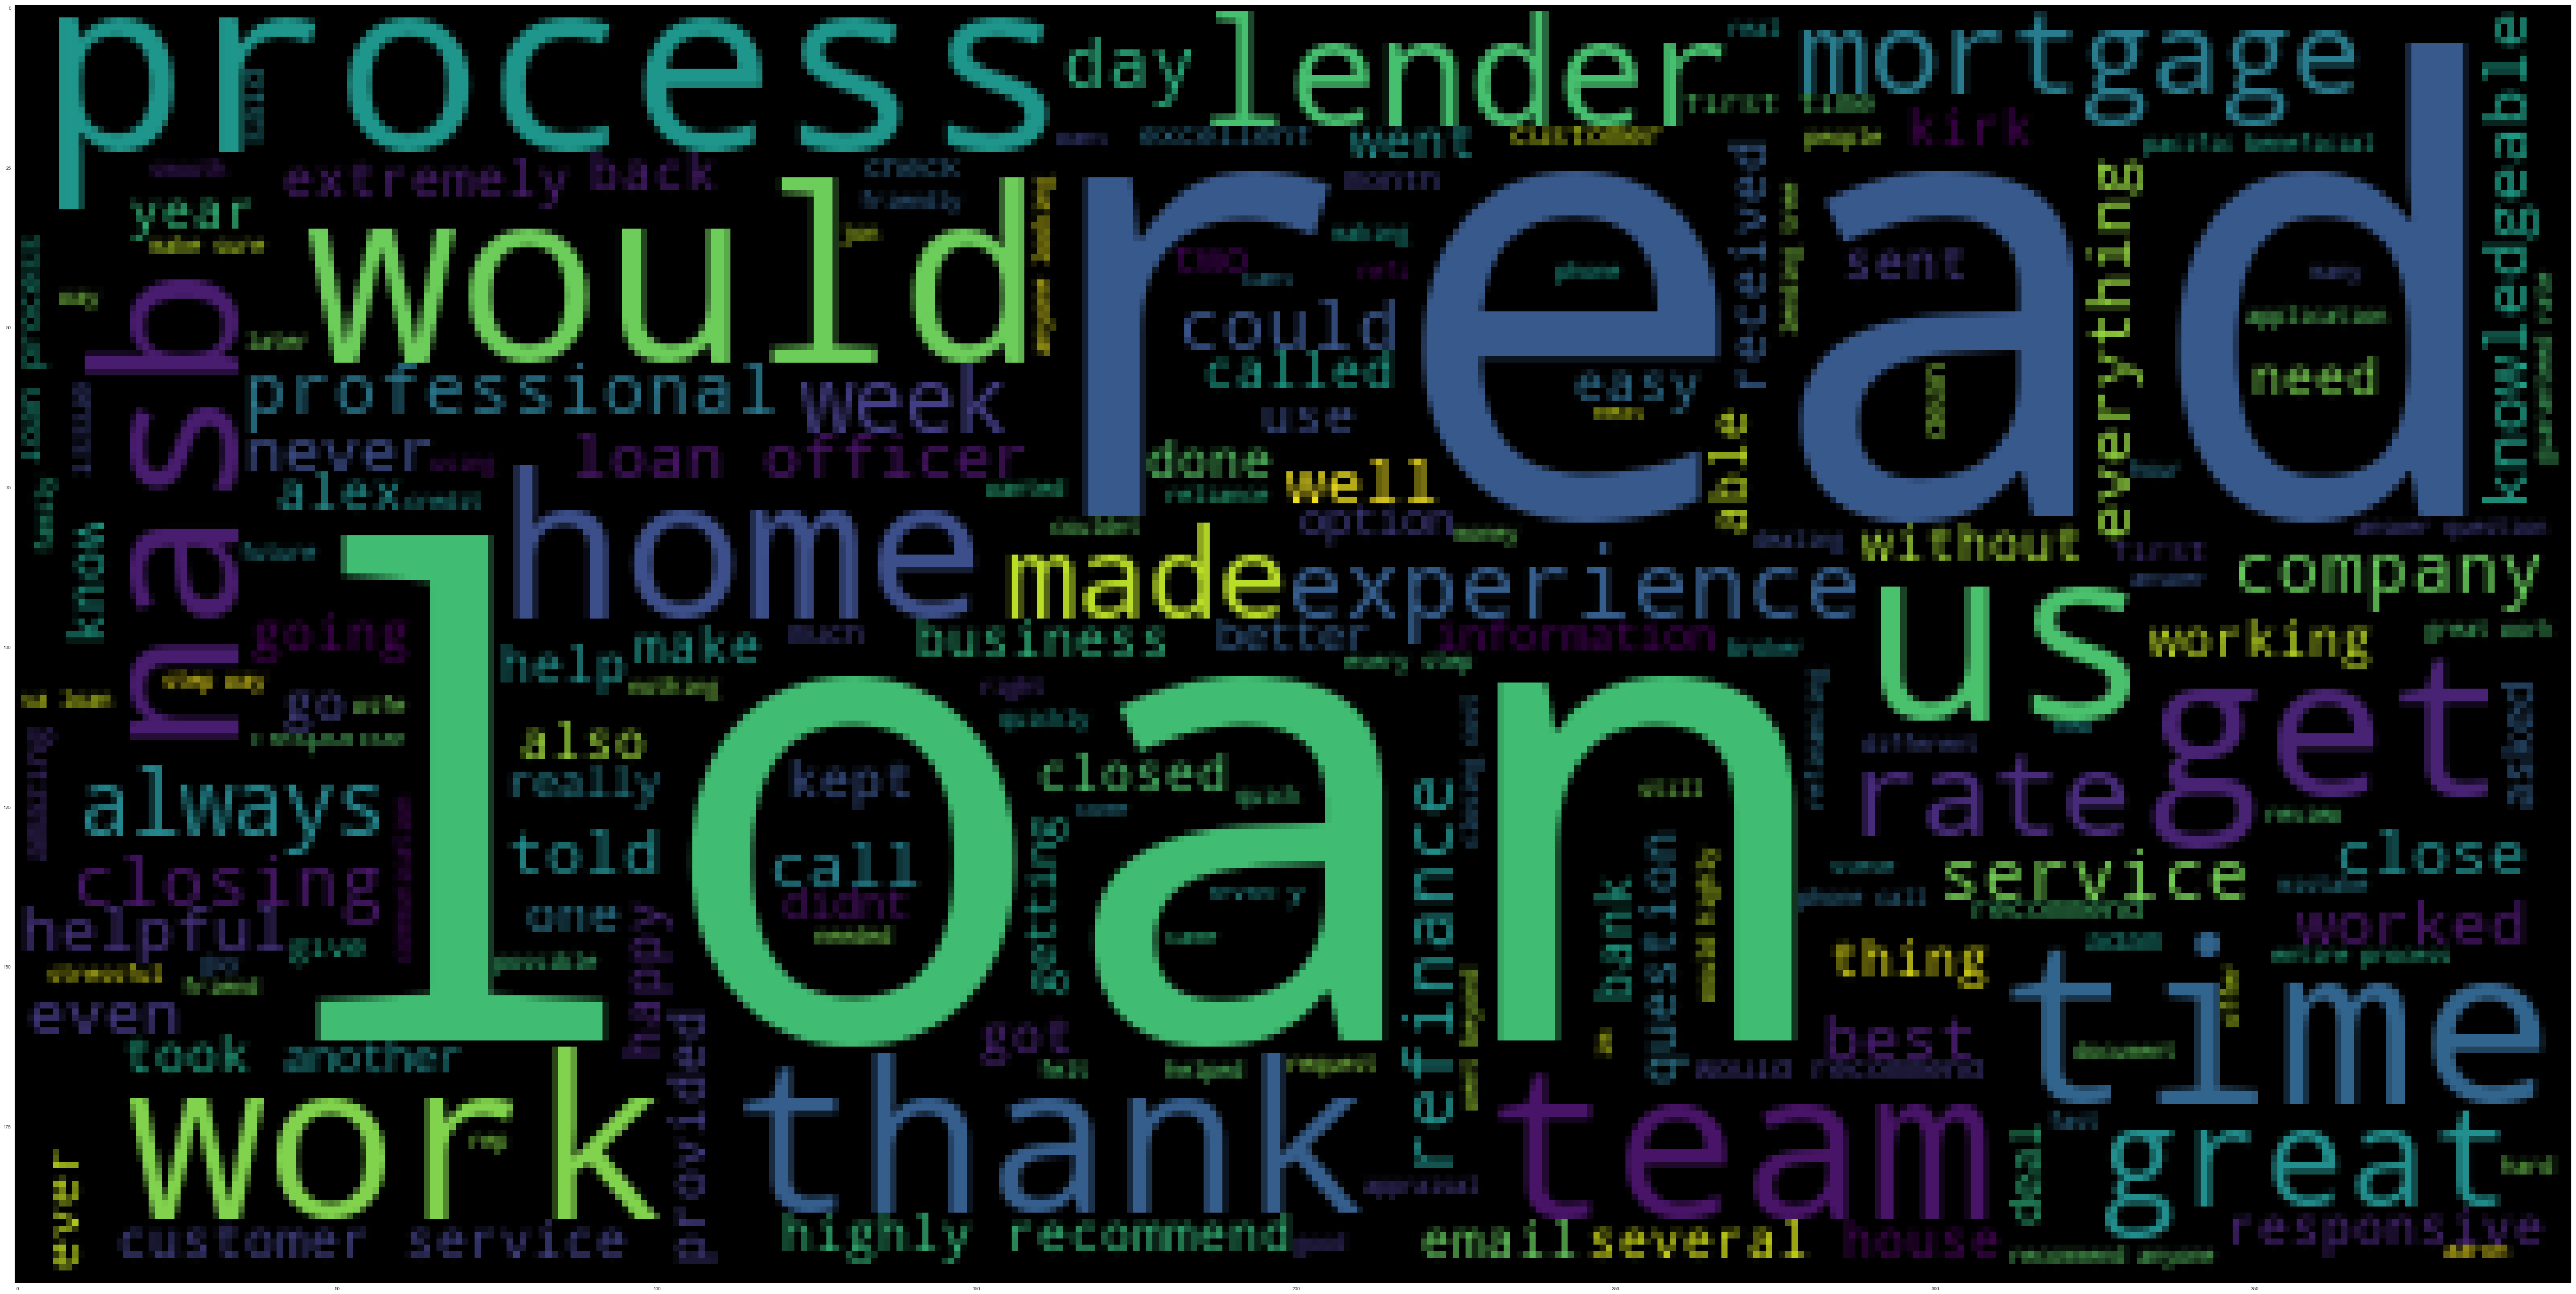

In [58]:
wordcloud = WordCloud(stopwords=[]).generate(' '.join(X_train.tolist()))

%matplotlib inline
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)

# Create user defined function for train the models

In [59]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

## Building different models with different vectors


In [61]:
#Naive Bayes
# Naive Bayes on Count Vectors and TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB  for L1, Count Vectors: ", accuracy_L1)

NB  for L1, Count Vectors:  0.889763779527559


In [62]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count, y_test)
print("NB  for L1, WordLevel TF-IDF: ", accuracy_L1)

NB  for L1, WordLevel TF-IDF:  0.952755905511811


In [63]:
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("NB  for L1, N-Gram Vectors: ", accuracy_L1)



# Naive Bayes on Character Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("NB for L1, CharLevel Vectors: ", accuracy_L1)

NB  for L1, N-Gram Vectors:  0.9133858267716536
NB for L1, CharLevel Vectors:  0.8031496062992126


In [64]:
#Logistic Regression
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Logistic Regression on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# Logistic Regression on Character Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.8661417322834646
LR  for L1, WordLevel TF-IDF:  0.9448818897637795
LR  for L1, N-Gram Vectors:  0.84251968503937
LR for L1, CharLevel Vectors:  0.8031496062992126


In [65]:
#Linear SVC
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(svm.LinearSVC(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("SVC  for L1, Count Vectors: ", accuracy_L1)



# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_count, y_train, xtest_count, y_test)
print("SVC  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Linear SVC on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("SVC  for L1, N-Gram Vectors: ", accuracy_L1)



# Linear SVC on Character Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("SVC for L1, CharLevel Vectors: ", accuracy_L1)

SVC  for L1, Count Vectors:  0.952755905511811
SVC  for L1, WordLevel TF-IDF:  0.968503937007874
SVC  for L1, N-Gram Vectors:  0.952755905511811
SVC for L1, CharLevel Vectors:  0.889763779527559


## Adding Features to a Document-Term Matrix

In [66]:
# create a DataFrame that only contains the 5-star and 1-star reviews
#reviews = reviews[(reviews.Stars==5) | (reviews.Stars==1)]

# define X and y
feature_cols = ['ReviewCleaned', 'sentiment']
X = df[feature_cols]
y = df.Stars

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [68]:
# use CountVectorizer with text column only
vect = TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000, min_df=5, ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train.ReviewCleaned)
X_test_dtm = vect.transform(X_test.ReviewCleaned)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('ReviewCleaned', axis=1).shape

(378, 614)
(127, 614)


(378, 1)

In [69]:
# cast other feature columns to float and convert to a sparse matrix
extra = sparse.csr_matrix(X_train.drop('ReviewCleaned', axis=1).astype(float))
extra.shape

# combine sparse matrices
X_train_dtm_extra = sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

# repeat for testing set
extra = sparse.csr_matrix(X_test.drop('ReviewCleaned', axis=1).astype(float))
X_test_dtm_extra = sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(127, 615)

In [70]:
# use logistic regression with text column only
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
print(metrics.accuracy_score(y_test, y_pred_class))

0.968503937007874


In [71]:
# use logistic regression with all features
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm_extra, y_train)
y_pred_class = logreg.predict(X_test_dtm_extra)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9606299212598425
